In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import blackjack

seed = 42
env = gym.make("Blackjack-v2")
# Policy that sticks only on a sum of 20 or 21
policy = np.zeros(tuple(env.observation_space.nvec) + (env.action_space.n,), dtype=np.float32) 
policy[-3:, :, :, 0] = 1.0
policy[:-3, :, :, 1] = 1.0
action_str = ["stick", "hit"]
env.reset(seed=seed)
np.random.seed(seed)

def get_action(policy, state):
    return np.random.choice(env.action_space.n, p=policy[tuple(state - env.observation_space.start)].flatten())

def plot_value(value, title=None):
    plt.imshow(value[-2:0:-1, 1:], cmap="plasma", vmin=-1.0, vmax=1.0)
    if title is not None:
        plt.title(title)
    plt.xlabel("Dealer showing")
    plt.xticks(range(10), labels=["A", 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.ylabel("Player sum")
    plt.yticks(range(env.observation_space.nvec[0]-2), labels=list(range(21, env.observation_space.start[0], -1)))
    plt.colorbar()
    plt.show()

def plot_policy(policy, title=None):
    deterministic = np.argmax(policy, axis=-1)
    plt.imshow(deterministic[-2::-1, 1:], cmap="winter", vmin=-0.25, vmax=1.25)
    if title is not None:
        plt.title(title)
    plt.xlabel("Dealer showing")
    plt.xticks(range(env.observation_space.nvec[1]-1), labels=["A", 2, 3, 4, 5, 6, 7, 8, 9, 10])
    plt.ylabel("Player sum")
    plt.yticks(range(env.observation_space.nvec[0]-1), labels=list(range(21, env.observation_space.start[0]-1, -1)))
    cbar = plt.colorbar(ticks=[0, 1])
    cbar.set_ticklabels(["Stick", "Hit"])
    plt.show()

In [2]:
state, info = env.reset()
print("Info:", info)
print("Initial state:", state)

Info: {'player': [6, 10], 'player_sum': 16, 'dealer_card': 2}
Initial state: [16  2  0]


In [3]:
action = get_action(policy, state)
state, reward, terminated, _, info = env.step(action)
print("Action:", action_str[action])
print("Reward:", reward)
print("Terminated", terminated)
print("Info:", info)
print("State:", state)

Action: hit
Reward: 0.0
Terminated False
Info: {'player': [6, 10, 3], 'player_sum': 19, 'dealer_card': 2}
State: [19  2  0]


In [4]:
gamma = 1.0
nvec = env.observation_space.nvec
num_states = nvec.prod()
num_actions = env.action_space.n
A = env.unwrapped.prob.reshape(num_states, num_actions, num_states)
b = (A * env.unwrapped.rewards.reshape(num_states, num_actions, num_states)).sum(axis=2, keepdims=True)

terminal_states = [(i, 0, k) for i in range(nvec[0]) for k in range(nvec[2])]
terminal_states += [(nvec[0]-1, j, k) for j in range(nvec[1]) for k in range(nvec[2])]
terminal = np.arange(num_states).reshape(nvec)[tuple(zip(*terminal_states))]
diagonal = np.diag(np.logical_not(np.logical_or.reduce(np.eye(num_states)[terminal])))

Analytical Solution

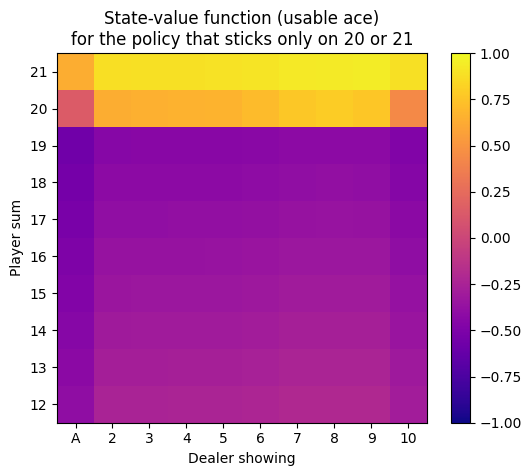

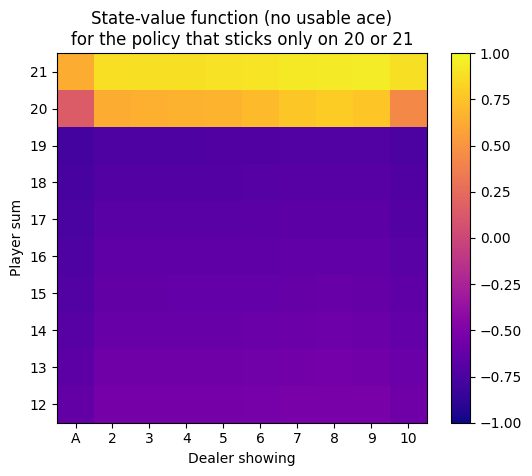

In [5]:
# Policy Evaluation
pol_eval = policy.reshape(num_states, 1, num_actions)
A_eval = diagonal - gamma * (pol_eval @ A).squeeze()
b_eval = (pol_eval @ b).squeeze()
v_eval = np.linalg.solve(A_eval, b_eval)

v = v_eval.reshape(nvec)
plot_value(v[:, :, 1], title="State-value function (usable ace)\nfor the policy that sticks only on 20 or 21")
plot_value(v[:, :, 0], title="State-value function (no usable ace)\nfor the policy that sticks only on 20 or 21")

#### Figure 5.1

First-visit MC prediction, for estimating $V \approx v_\pi$

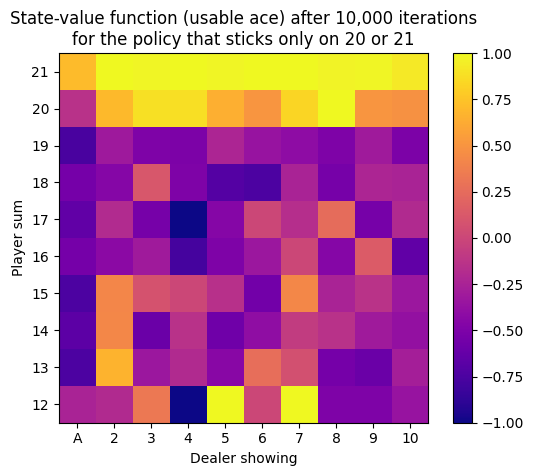

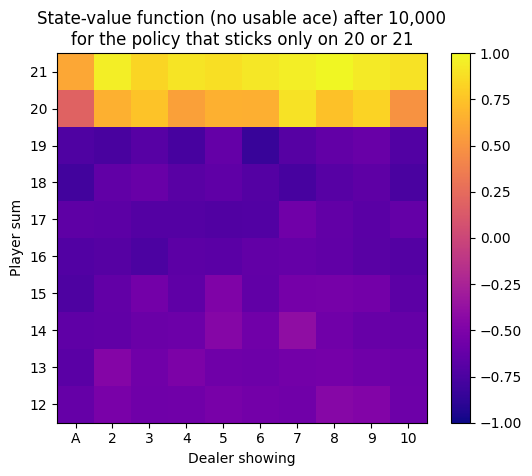

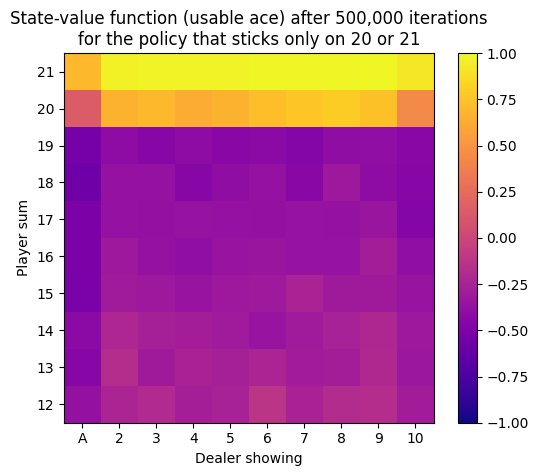

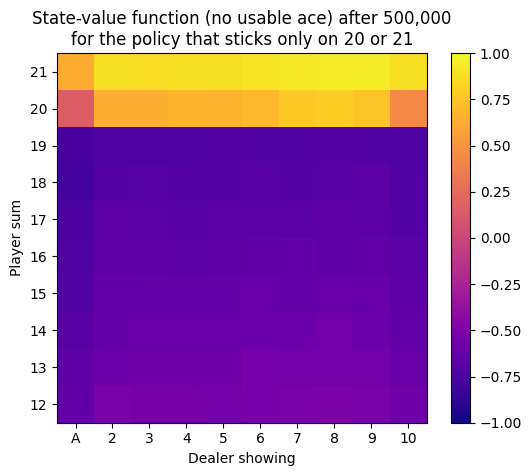

In [6]:
v_eval = np.zeros(nvec)
count = np.zeros(nvec, dtype=int)

num_episodes = int(5e5)
for i in range(num_episodes):
    state, _ = env.reset()

    # Generate an episode following policy
    T = 0
    states = [tuple(state)]
    rewards = []
    terminated = False
    while not terminated:
        action = get_action(policy, state)
        state, reward, terminated, _, _ = env.step(action)
        states.append(tuple(state))
        rewards.append(reward)
        T += 1

    # Episode return for every firs-visit state
    ep_return = 0.0
    for t in range(T-1, -1, -1):
        ep_return = rewards[t] + gamma * ep_return
        if states[t] not in states[:t]:
            state = tuple(states[t] - env.observation_space.start)
            count[state] += 1
            v_eval[state] += (ep_return - v_eval[state]) / count[state]

    if i == int(1e4):
        plot_value(v_eval[:, :, 1], title=f"State-value function (usable ace) after {i:,} iterations\nfor the policy that sticks only on 20 or 21")
        plot_value(v_eval[:, :, 0], title=f"State-value function (no usable ace) after {i:,}\nfor the policy that sticks only on 20 or 21")

plot_value(v_eval[:, :, 1], title=f"State-value function (usable ace) after {num_episodes:,} iterations\nfor the policy that sticks only on 20 or 21")
plot_value(v_eval[:, :, 0], title=f"State-value function (no usable ace) after {num_episodes:,}\nfor the policy that sticks only on 20 or 21")

#### Exercise 5.1
Consider the diagrams on the right in Figure 5.1. Why does the estimated value function jump up for the last two rows in the rear? Why does it drop off for the whole last row on the left? Why are the frontmost values higher in the upper diagrams than in the lower?

- ***The estimated value function jumps up fot the last two rows in the rear because sticking on a player sum of 20 and 21 can be considered a good policy, whereas hitting below 20 could be considered not as good as if the player sticks.***
- ***It drops off for the whole last row on the left because that indicates that the dealer has an ace, with a very high probability (4/13) that its second card is a 10, having a natural and the player can only draw or lose.***
- ***The frontmost values are higher in the upper diagram because that indicates the player has a usable ace and its sum is 12, giving the player more flexibility when hitting. Also, the player doesn't lose (copared to the lower diagram) if the next card is a 10***

#### Exercise 5.2
Suppose every-visit MC was used instead of first-visit MC on the blackjack task. Would you expect the results to be very diferent? Why or why not?

- ***The results will be very similar because on the blackjack task the only way to visit non-terminal staes is by hitting, once you hit, it is not possible to return to a previous state with the same player sum and usable ace conditions.***

#### Exercise 5.3
What is the backup diagram for Monte Carlo estimation of $q_\pi$ ?

- ***For Monte Carlo estimation of $q_\pi$, the root is an action node, and below is the entire trajectory of transitions along a particular single episode, ending at the terminal state.***

#### Exercise 5.4
The pseudocode for Monte Carlo ES is inefficient because, for each state–action pair, it maintains a list of all returns and repeatedly calculates their mean. It would be more efficient to use techniques similar to those explained in Section 2.4 to maintain just the mean and a count (for each state–action pair) and update them incrementally. Describe how the pseudocode would be altered to achieve this.

- ***During initialization***\
    $N(s, a) \leftarrow 0, \text{ for all } s \in \mathcal{S}, a \in \mathcal{A}$
- ***Update Q-values***\
    $N(S_t, A_t) \leftarrow N(S_t, A_t) + 1$\
    $Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{G - Q(S_t, A_t)}{N(S_t, A_t)}$

Analytical Solution

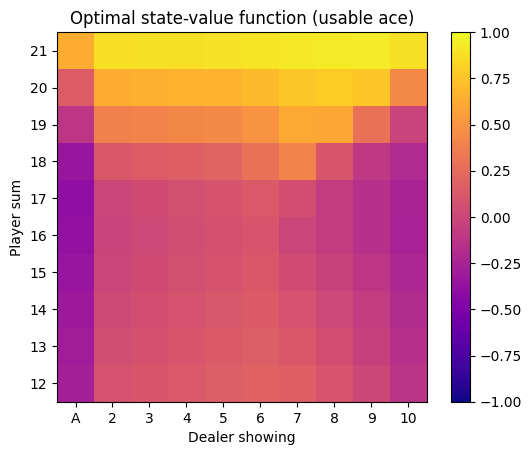

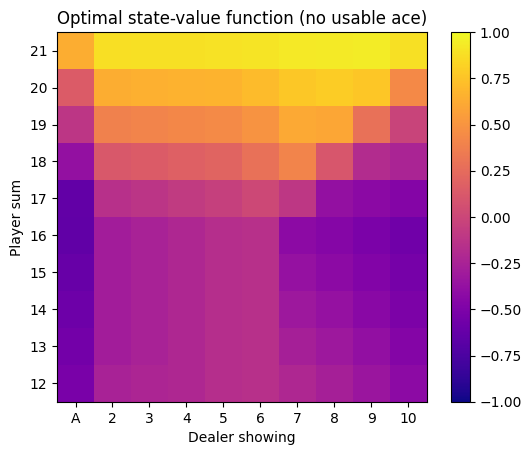

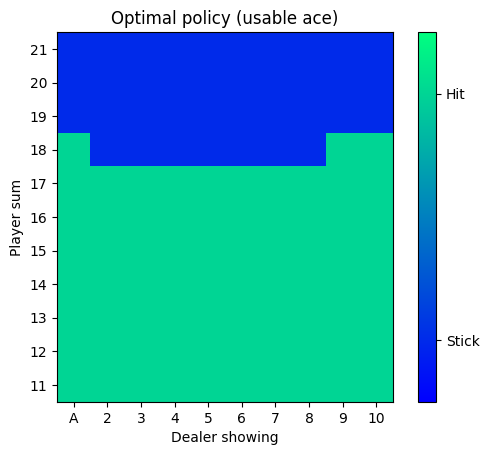

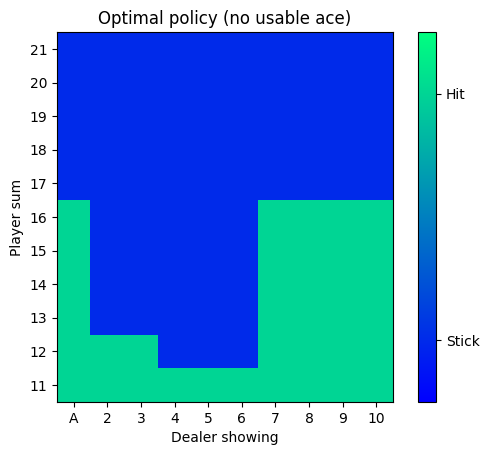

In [7]:
policy = 0.5 * np.ones((*nvec, num_actions), dtype=np.float32)

while True:
    # Policy Evaluation
    pol_eval = policy.reshape(num_states, 1, num_actions)
    A_eval = diagonal - gamma * (pol_eval @ A).squeeze()
    b_eval = (pol_eval @ b).squeeze()
    v_eval = np.linalg.solve(A_eval, b_eval)

    # Policy Improvement
    old_policy = policy.copy()
    A_impr = gamma * A @ v_eval + b.squeeze()
    argmax = A_impr == np.max(A_impr, axis=1, keepdims=True)
    policy = (argmax / np.sum(argmax, axis=1, keepdims=True))
    policy = policy.reshape(tuple(nvec) + (num_actions,))
    if not np.any(policy - old_policy):
        break

v = v_eval.reshape(nvec)
plot_value(v[:, :, 1], title="Optimal state-value function (usable ace)")
plot_value(v[:, :, 0], title="Optimal state-value function (no usable ace)")

plot_policy(policy[:, :, 1], title="Optimal policy (usable ace)")
plot_policy(policy[:, :, 0], title="Optimal policy (no usable ace)")

#### Figure 5.2

Monte Carlo ES (Exploring Starts), for estimating $\pi \approx \pi_*$

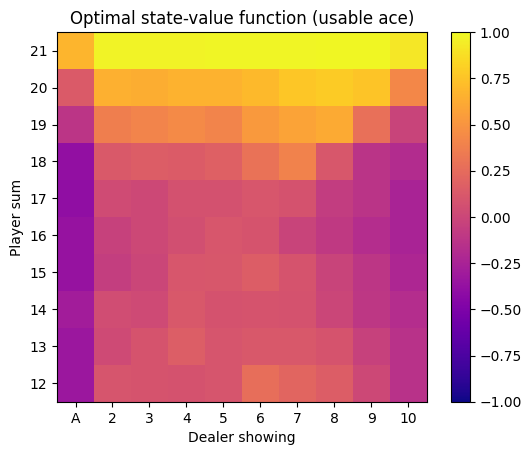

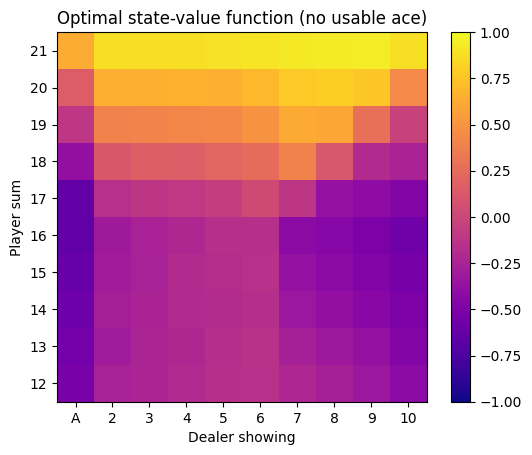

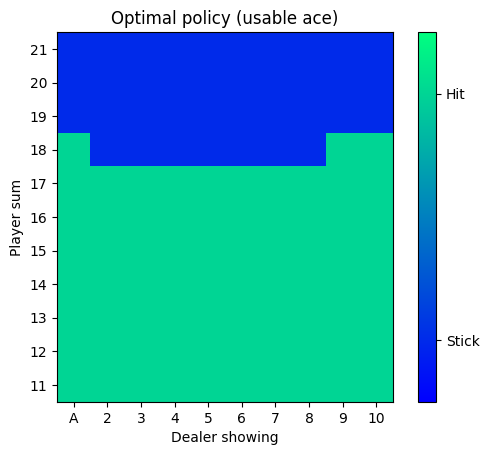

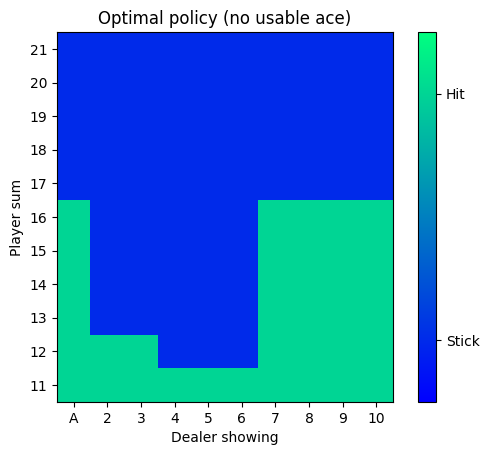

In [8]:
policy = 0.5 * np.ones((*nvec, num_actions), dtype=np.float32)
policy[0, :, 1, 0] = 0.0
policy[0, :, 1, 1] = 1.0
q = np.zeros((*nvec, num_actions))
count = np.zeros((*nvec, num_actions), dtype=int)

num_episodes = int(2e6)
for _ in range(num_episodes):
    state, _ = env.reset()
    action = np.random.choice(num_actions)

    # Generate an episode following policy
    T = 0
    states = [tuple(state)]
    actions = []
    rewards = []
    terminated = False
    while not terminated:
        state, reward, terminated, _, _ = env.step(action)
        states.append(tuple(state))
        actions.append(action)
        rewards.append(reward)
        action = get_action(policy, state)
        T += 1

    # Episode return for every firs-visit state
    ep_return = 0.0
    for t in range(T-1, -1, -1):
        ep_return = rewards[t] + gamma * ep_return
        if (states[t], actions[t]) not in zip(states[:t], actions[:t]):
            state = tuple(states[t] - env.observation_space.start)
            action = actions[t]
            count[state][action] += 1
            q[state][action] += (ep_return - q[state][action]) / count[state][action]
            argmax = q[state] == np.max(q[state])
            policy[state] = argmax / np.sum(argmax)

v = (policy * q).sum(axis=-1)
plot_value(v[:, :, 1], title=f"Optimal state-value function (usable ace)")
plot_value(v[:, :, 0], title=f"Optimal state-value function (no usable ace)")

plot_policy(policy[:, :, 1], title="Optimal policy (usable ace)")
plot_policy(policy[:, :, 0], title="Optimal policy (no usable ace)")

On-policy first-visit MC control (for $\epsilon$-soft policies), estimates $\pi \approx \pi_*$

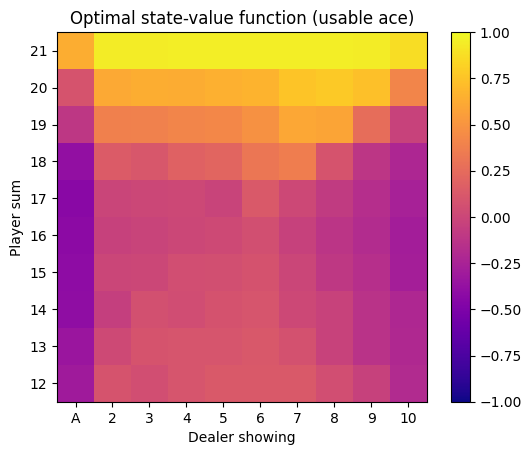

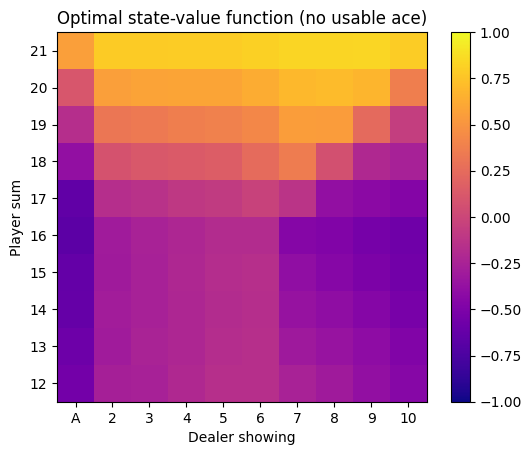

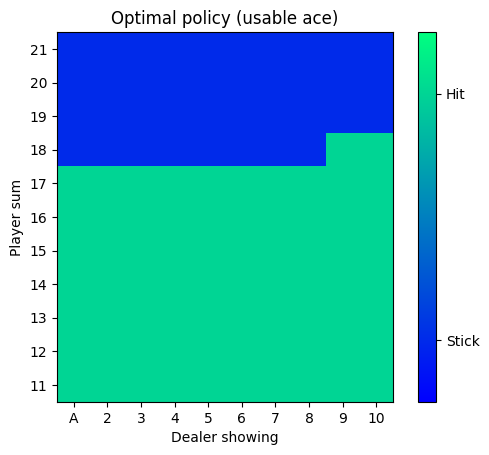

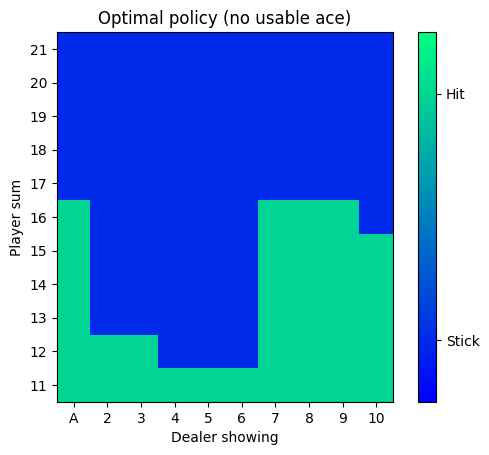

In [9]:
epsilon = 0.1
policy = 0.5 * np.ones((*nvec, num_actions), dtype=np.float32)
policy[0, :, 1, 0] = 0.0
policy[0, :, 1, 1] = 1.0
q = np.zeros((*nvec, num_actions))
count = np.zeros((*nvec, num_actions), dtype=int)

num_episodes = int(2e6)
for _ in range(num_episodes):
    state, _ = env.reset()

    # Generate an episode following policy
    T = 0
    states = [tuple(state)]
    actions = []
    rewards = []
    terminated = False
    while not terminated:
        action = get_action(policy, state)
        state, reward, terminated, _, _ = env.step(action)
        states.append(tuple(state))
        actions.append(action)
        rewards.append(reward)
        T += 1

    # Episode return for every firs-visit state
    ep_return = 0.0
    for t in range(T-1, -1, -1):
        ep_return = rewards[t] + gamma * ep_return
        if (states[t], actions[t]) not in zip(states[:t], actions[:t]):
            state = tuple(states[t] - env.observation_space.start)
            action = actions[t]
            count[state][action] += 1
            q[state][action] += (ep_return - q[state][action]) / count[state][action]
            argmax = q[state] == np.max(q[state])
            policy[state] = np.where(argmax, (1 - epsilon) / np.sum(argmax) + epsilon / num_actions, epsilon / num_actions)

v = (policy * q).sum(axis=-1)
plot_value(v[:, :, 1], title=f"Optimal state-value function (usable ace)")
plot_value(v[:, :, 0], title=f"Optimal state-value function (no usable ace)")

plot_policy(policy[:, :, 1], title="Optimal policy (usable ace)")
plot_policy(policy[:, :, 0], title="Optimal policy (no usable ace)")

#### Exercise 5.5
Consider an MDP with a single nonterminal state and a single action that transitions back to the nonterminal state with probability $p$ and transitions to the terminal state with probability $1−p$. Let the reward be $+1$ on all transitions, and let $\gamma=1$. Suppose you observe one episode that lasts 10 steps, with a return of 10. What are the first-visit and every-visit estimators of the value of the nonterminal state?

- $\text{First-visit}: v(s) = +10$
- $\text{Every-visit}: v(s) = (+1+2+3+4+5+6+7+8+9+10)/10 = +5.5$

#### Figure 5.3

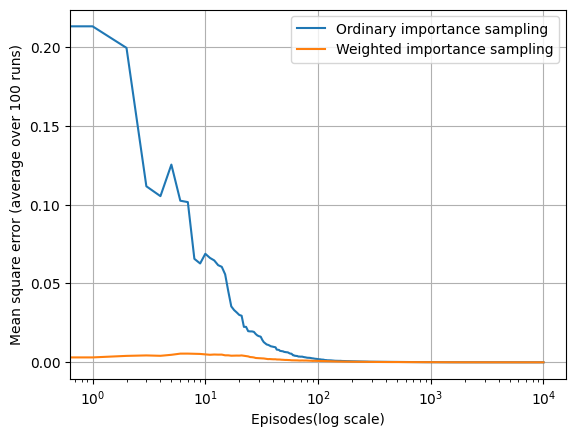

In [10]:
# Target policy that sticks only on a sum of 20 or 21
policy = np.zeros((*nvec, num_actions), dtype=np.float32)
policy[-3:, :, :, 0] = 1.0
policy[:-3, :, :, 1] = 1.0

# Analytic Policy Evaluation
pol_eval = policy.reshape(num_states, 1, num_actions)
A_eval = diagonal - gamma * (pol_eval @ A).squeeze()
b_eval = (pol_eval @ b).squeeze()
v_eval = np.linalg.solve(A_eval, b_eval)
v = v_eval.reshape(nvec)

# Value of initial state
options = {"init_state": {"player": [1, 2], "dealer": [2]}}
state, _ = env.reset(options=options)
target_value = v[tuple(state - env.observation_space.start)]

# Behavior policy
behavior = 0.5 * np.ones((*nvec, num_actions), dtype=np.float32)

# Importance sampling
num_runs = 100
num_episodes = int(1e4)
mse_ordinary = np.zeros(num_episodes)
mse_weighted = np.zeros(num_episodes)

for _ in range(num_runs):
    count_ordinary = 0
    count_weighted = 0.0
    value_ordinary = 0.0
    value_weighted = 0.0
    for i in range(num_episodes):
        state, _ = env.reset(options=options)

        T = 0
        states = [tuple(state)]
        actions = []
        rewards = []
        terminated = False
        while not terminated:
            action = get_action(behavior, state)
            state, reward, terminated, _, _ = env.step(action)
            states.append(tuple(state))
            actions.append(action)
            rewards.append(reward)
            T += 1

        ratio = 1.0
        ep_return = 0.0
        for t in range(T-1, -1, -1):
            ep_return = rewards[t] + gamma * ep_return
            state = tuple(states[t] - env.observation_space.start)
            action = actions[t]
            ratio *= policy[state][action] / behavior[state][action]
            if t == 0:
                count_ordinary += 1
                count_weighted += ratio
                value_ordinary += ratio * (ep_return - value_ordinary) / count_ordinary
                value_weighted += ratio * (ep_return - value_weighted) / count_weighted if count_weighted else 0.0
                mse_ordinary[i] += (target_value - value_ordinary) ** 2
                mse_weighted[i] += (target_value - value_weighted) ** 2

mse_ordinary /= num_episodes
mse_weighted /= num_episodes
plt.plot(mse_ordinary, label="Ordinary importance sampling")
plt.plot(mse_weighted, label="Weighted importance sampling")
plt.xlabel("Episodes(log scale)")
plt.xscale("log")
plt.ylabel(f"Mean square error (average over {num_runs} runs)")
plt.legend()
plt.grid(True)
plt.show()

In [11]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import inf_var

seed = 42
env = gym.make("InfiniteVar-v0")
# Policy that selects always left
policy = np.zeros((env.observation_space.n, env.action_space.n), dtype=np.float32)
policy[:, 0] = 1.0
action_str = ["left", "right"]
env.reset(seed=seed)
np.random.seed(seed)

def get_action(policy, state):
    return np.random.choice(env.action_space.n, p=policy[state].flatten())

In [12]:
state, info = env.reset()
print("Initial state:", state)

Initial state: 0


In [13]:
action = get_action(policy, state)
state, reward, terminated, _, info = env.step(action)
print("Action:", action_str[action])
print("Reward:", reward)
print("Terminated", terminated)
print("State:", state)

Action: left
Reward: 0.0
Terminated False
State: 0


#### Figure 5.4

***Note: The following implementation converges to the correct value in less iterations, the original figure from the book averages the returns over may independent episodes instead of updating the value from episode to episode. Additionally, the original figure divides the accumulated returns over the current number of episodes, even if the episode has a ratio of 0 (not contribuiting to the estimate).***

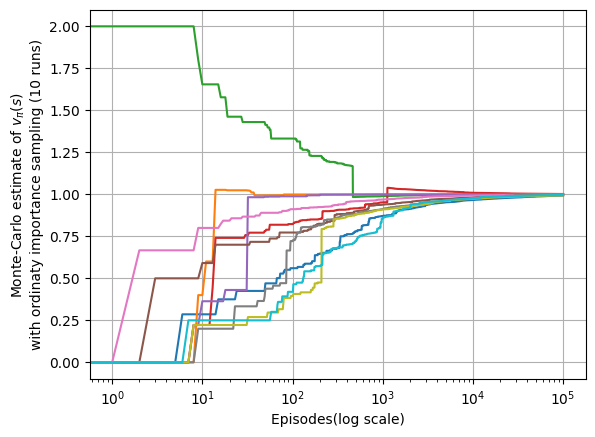

In [14]:
gamma = 1.0

# Behavior policy
behavior = 0.5 * np.ones((env.observation_space.n, env.action_space.n), dtype=np.float32)

# Importance sampling
num_runs = 10
num_episodes = int(1e5)
value_curves = np.zeros((num_runs, num_episodes))

for run in range(num_runs):
    count = 0
    value = 0.0
    for i in range(num_episodes):
        state, _ = env.reset()

        T = 0
        states = [state]
        actions = []
        rewards = []
        terminated = False
        while not terminated:
            action = get_action(behavior, state)
            state, reward, terminated, _, _ = env.step(action)
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            T += 1

        ratio = 1.0
        ep_return = 0.0
        for t in range(T-1, -1, -1):
            ep_return = rewards[t] + gamma * ep_return
            state = states[t]
            action = actions[t]
            ratio *= policy[state][action] / behavior[state][action]
            if t == 0:
                count += 1
                value += ratio * (ep_return - value) / count
                value_curves[run][i] = value

for curve in value_curves:
    plt.plot(curve)
plt.xlabel("Episodes(log scale)")
plt.xscale("log")
plt.ylabel(f"Monte-Carlo estimate of $v_\pi(s)$\nwith ordinaty importance sampling ({num_runs} runs)")
plt.grid(True)
plt.show()

#### Exercise 5.6
What is the equation analogous to (5.6) for action values $Q(s,a)$ instead of state values $V(s)$, again given returns generated using $b$?

- $Q(s,a) \doteq \frac{\sum_{t \in \mathcal{T}(s,a)} \rho_{t+1:T(t)-1}G_t}{\sum_{t \in \mathcal{T}(s,a)} \rho_{t+1:T(t)-1}}$

#### Exercise 5.7
In learning curves such as those shown in Figure 5.3 error generally decreases with training, as indeed happened for the ordinary importance-sampling method. But for the weighted importance-sampling method error first increased and then decreased. Why do you think this happened?

- ***The weighted importance sampling is biased and starts with values closer to the value function of the behavior policy $b$ (i.e. $v_b(s)$). After some episodes it starts to shift up towards the target policy $\pi$, and due to the value function of the target policy (i.e. $v_\pi(s)$) is decreasing, the weighted importance sampling value also starts to decrease.***

#### Exercise 5.8
The results with Example 5.5 and shown in Figure 5.4 used a first-visit MC method. Suppose that instead an every-visit MC method was used on the same problem. Would the variance of the estimator still be infinite? Why or why not?

- ***The variance will remain infinite because finite variance is only guaranteed for the weighted importance samplig using the first-visit MC method.***
- ***The variance will be infinite if the expectation of the square of the every-visit importance-sampling-scaled return is infinite***
- $\mathbb{E}[(\sum_{t \in \mathcal{T}(s)}\prod_t^{T(t)-1} \frac{\pi(A_t|S_t)}{b(A_t|S_t)}G_t)^2] = 0.2 \sum_{k=0}^{\infty}0.45^k(2^{k+1}-1)^2 = 0.8 \sum_{k=0}^{\infty}1.8^k - \frac{84}{11} = \infty$

#### Exercise 5.9
Modify the algorithm for first-visit MC policy evaluation (Section 5.1) to use the incremental implementation for sample averages described in Section 2.4.

- ***During initialization***\
    $C(s) \leftarrow 0, \text{ for all } s \in \mathcal{S}$
- ***Update Values***\
    $C(S_t) \leftarrow C(S_t) + 1$\
    $V(S_t) \leftarrow V(S_t) + \frac{G - V(S_t)}{C(S_t)}$

### Exercise 5.10
Derive the weighted-average update rule (5.8) from (5.7). Follow the pattern of the derivation of the unweighted rule (2.3).

- $V_{n+1} = \frac{\sum_{k=1}^{n}W_kG_k}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = \frac{W_nG_n+\sum_{k=1}^{n-1}W_kG_k}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = \frac{W_nG_n+(\sum_{k=1}^{n-1}W_k)\sum_{k=1}^{n-1}W_kG_k/(\sum_{k=1}^{n-1}W_k)}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = \frac{W_nG_n+(\sum_{k=1}^{n-1}W_k)V_n}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = \frac{W_nG_n+(\sum_{k=1}^{n}W_k-W_n)V_n}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = \frac{W_nG_n+\sum_{k=1}^{n}W_kV_n-W_nV_n}{\sum_{k=1}^{n}W_k}$\
$V_{n+1} = V_n+\frac{W_n(G_n-V_n)}{\sum_{k=1}^{n}W_k}$

#### Exercise 5.11
In the boxed algorithm for o↵-policy MC control, you may have been expecting the $W$ update to have involved the importance-sampling ratio $\frac{\pi(At|St)}{b(At|St)}$, but instead it involves $\frac{1}{b(At|St)}$. Why is this nevertheless correct?

- ***It is correct because the target policy is deterministic, meaning that the probability of selection action $A_t$ given $S_t$ is always $1$***

#### Exercise 5.12: Racetrack (programming)
Consider driving a race car around a turn like those shown in Figure 5.5. You want to go as fast as possible, but not so fast as to run off the track. In our simplified racetrack, the car is at one of a discrete set of grid positions, the cells in the diagram. The velocity is also discrete, a number of grid cells moved horizontally and vertically per time step. The actions are increments to the velocity components. Each may be changed by $+1$, $−1$, or $0$ in each step, for a total of nine $(3 \times 3)$ actions. Both velocity components are restricted to be nonnegative and less than $5$, and they cannot both be zero except at the starting line. Each episode begins in one of the randomly selected start states with both velocity components zero and ends when the car crosses the finish line. The rewards are $−1$ for each step until the car crosses the finish line. If the car hits the track boundary, it is moved back to a random position on the starting line, both velocity components are reduced to zero, and the episode continues. Before updating the car’s location at each time step, check to see if the projected path of the car intersects the track boundary. If it intersects the finish line, the episode ends; if it intersects anywhere else, the car is considered to have hit the track boundary and is sent back to the starting line. To make the task more challenging, with probability $0.1$ at each time step the velocity increments are both zero, independently of the intended increments. Apply a Monte Carlo control method to this task to compute the optimal policy from each starting state. Exhibit several trajectories following the optimal policy (but turn the noise off for these trajectories).

In [4]:
import numpy as np
import gymnasium as gym
import racetrack

seed = 42
env = gym.make("Racetrack-v0")
env.reset(seed=seed)
np.random.seed(seed)

In [5]:
env.reset()
env.render()

In [6]:
action = (0, 0)
env.step(action)
env.render()

Off-policy MC prediction (policy evaluation) for estimating $Q \approx q_\pi$

Off-policy MC control, for estimating $\pi \approx \pi_*$